# Mixture of Gaussian with Constraint

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import seaborn as sns; sns.set()

In [2]:
def init(n_cluster, std, X):
    Phi = np.full((n_cluster, ), 1 / n_cluster)
    Mu = np.random.uniform(X.min(), X.max(), size=n_cluster)
    print(Mu)
    return Phi, Mu 

In [3]:
def e_step(X, Phi, Mu, std):
    # w_ij
    W = np.zeros((len(X), len(Phi))) + 1e-14
    Norms = [norm(mu, std) for mu in Mu] 
    for i, x in enumerate(X):
        probs = [n.pdf(x) for n in Norms] 
        W[i, :] = (Phi * probs) / np.sum(Phi * probs)
    return W

In [4]:
def m_step(X, W):
    Phi = W.mean(axis=0)
    Mu = (W.T * X).T.sum(axis=0) / W.sum(axis=0)
    return Phi, Mu

In [17]:
def converged(old_Mu, Mu):
    return np.allclose(old_Mu, Mu, 0.0001)

In [32]:
def em(X, n_cluster, std):
    Phi, old_Mu = init(n_cluster, std, X)
    Mu = old_Mu + 1
    while not converged(old_Mu, Mu):
        W = e_step(X, Phi, Mu, std)
        old_Mu = Mu.copy()
        Phi, Mu = m_step(X, W)
        print(".", end='')
    return W, Phi, Mu

In [33]:
np.random.seed(0)
X = np.linspace(-5,5,num=10)
X0 = X*np.random.rand(len(X))+20 # Create data cluster 1
X1 = X*np.random.rand(len(X))-20 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above

In [47]:
W, Phi, Mu = em(X_tot, 3, 1)

[-19.22233668  22.30728267   7.20020568]
...

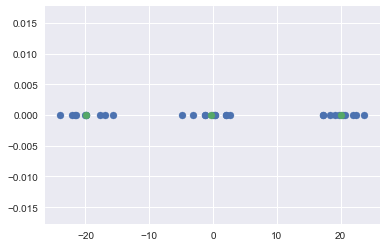

In [50]:
plt.scatter(X_tot, np.zeros(len(X_tot)))
plt.scatter(Mu, [0, 0, 0])